[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/main/notebooks/herculens__Starting_guide_complex_source.ipynb)

# Starting guide for a classic usage of `Herculens`

This notebooks shows a similar example as in the [Starting guide notebook](https://github.com/aymgal/herculens_workspace/blob/main/notebooks/herculens__Starting_guide.ipynb), but with a more complex source that requires a more flexible model.

__authors__: @aymgal

__last update__: 04/04/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git@new-param-interface
    !pip install --quiet git+https://github.com/aymgal/utax.git
    !pip install --quiet optax blackjax-nightly numpyro
    !pip install --quiet arviz corner

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 18.4 MB/s eta 0:00:00


In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
import corner
from pprint import pprint

# JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # uncomment for double precision
if IN_COLAB:
    _ = jnp.zeros(10)  # allocate the GPU memory
    #os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'  # temporary fix bug with latest JAX version (https://github.com/pyro-ppl/numpyro/issues/1542)

# NUTS Hamiltonian MC sampling
import blackjax

# probabilistic model
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints

# variational inference
import optax  # optimizers
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.RegulModel.regul_model import RegularizationModel
from herculens.Inference.loss import Loss
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.jaxopt import JaxoptOptimizer
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

## Simulate an observation of strong lens

### Define the coordinates grid

In [3]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Setup point spread function (PSF) and observation/noise properties

For simplicity we assume a Gaussian PSF but you can also provide an image of the PSF via `psy_type='PIXELATED'`

In [4]:
psf = PSF(psf_type='GAUSSIAN', fwhm=0.3)

noise = Noise(npix, npix, background_rms=1e-2, exposure_time=1000.)

### Lens galaxy

We assume a SIE embedded in an external shear

In [5]:
# Lens mass
lens_mass_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
print(e1, e2)
print(gamma1, gamma2)
kwargs_lens_input = [
    {'theta_E': 1.5, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

# Source light
source_model_input = LightModel(['SERSIC_ELLIPSE', 'GAUSSIAN'])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.1},
    {'amp': 1., 'sigma': 0.05, 'center_x': 0.3, 'center_y': 0.3} # add a bit of complexity in the source galaxy
]


0.13732309941975984 0.03937676511671417
-0.00927050983124842 0.02853169548885461


### Generate the lens image

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 2}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=42)

In [7]:
# Plotting engine
plotter = Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

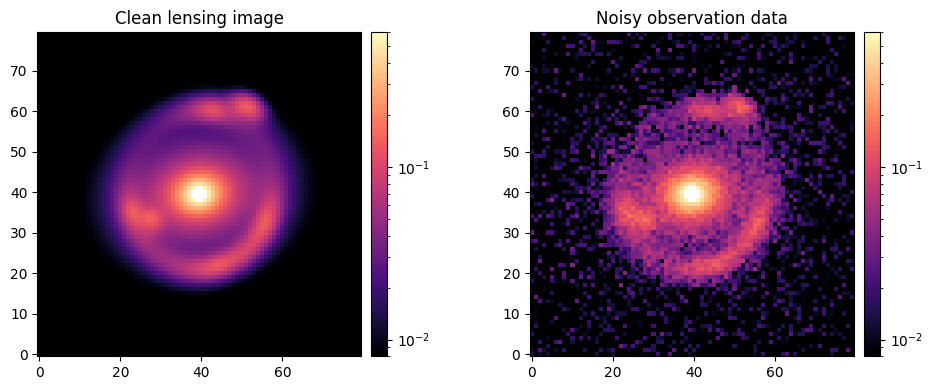

In [8]:
# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

## Fit the image with a fully smooth model

For this example we assume the same models as in the simulated data.

In [9]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model_input),
                         source_model_class=LightModel(['SERSIC_ELLIPSE']),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)

In [10]:
class ProbModel(NumpyroModel):
    
    def model(self):
        # Parameters of the source
        prior_source = [
          {
              'amp': numpyro.sample('source_amp', dist.LogNormal(1.0, 0.1)),
         'R_sersic': numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.2, 0.1, low=0.05)), 
         'n_sersic': numpyro.sample('source_n', dist.Uniform(1., 3.)), 
         'e1': numpyro.sample('source_e1', dist.TruncatedNormal(0.05, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('source_e2', dist.TruncatedNormal(0.05, 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('source_center_x', dist.Normal(0.05, 0.02)), 
        'center_y': numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))}
        ]

        # Parameters of the lens
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))

        # Parameters of the lens light, with center relative the lens mass
        prior_lens_light = [
        {'amp': numpyro.sample('light_amp', dist.LogNormal(2., 0.1)), 
         'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.1)), 
         'n_sersic': numpyro.sample('light_n', dist.Uniform(2., 5.)), 
         'e1': numpyro.sample('light_e1', dist.TruncatedNormal(0.1, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('light_e2', dist.TruncatedNormal(0.04, 0.05, low=-0.3, high=0.3)),
         'center_x': cx, 
         'center_y': cy}
        ]

        prior_lens = [
        # power-law
        {
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1)),
         'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(0.1, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(0.04, 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('lens_center_x', dist.Normal(cx, 0.005)), 
         'center_y': numpyro.sample('lens_center_y', dist.Normal(cy, 0.005))},
        # external shear, with fixed origin
        {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(-0.01, 0.05, low=-0.3, high=0.3)), 
         'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(0.03, 0.05, low=-0.3, high=0.3)), 
         'ra_0': 0.0, 'dec_0': 0.0}
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_var = noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}]}
        return kw

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 21


In [11]:
# visualize the probabilistic graph thanks to NumPyro utility
#prob_model.render_model()

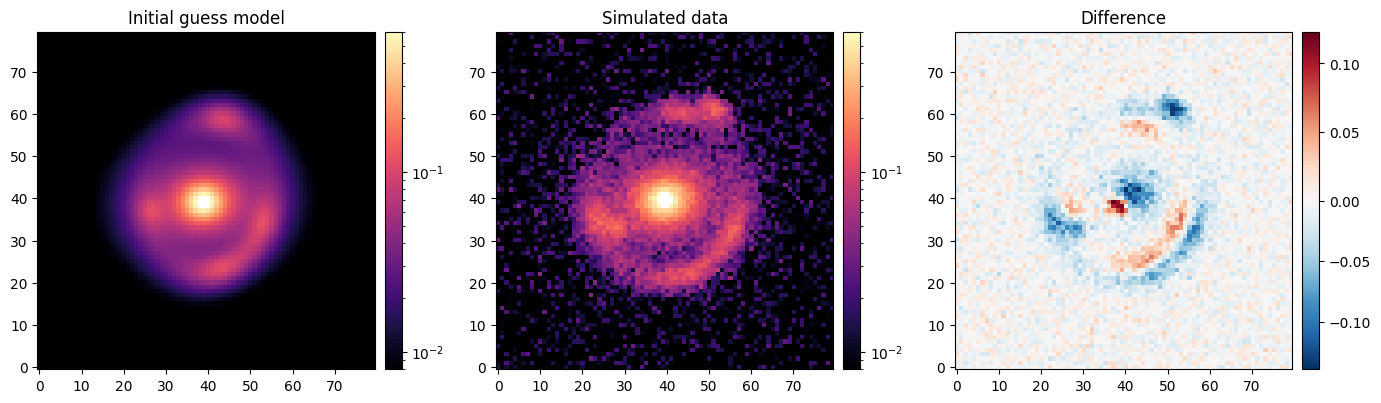

In [12]:
# visualize initial guess
init_params = prob_model.get_sample(seed=212)  # constrained space
init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [13]:
loss = Loss(prob_model)
print("Initial loss =", loss(init_params_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = -16110.9582360028


In [14]:
optimizer = JaxoptOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude
best_fit_unconst, logL_best_fit, extra_fields, runtime \
    = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
print("Runtime:", runtime)

Runtime: 8.981576204299927


Final loss = -19398.84455942367


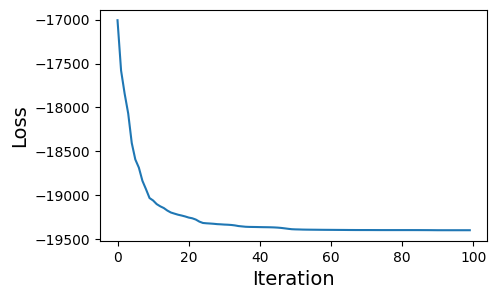

In [15]:
print("Final loss =", loss(best_fit_unconst))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()

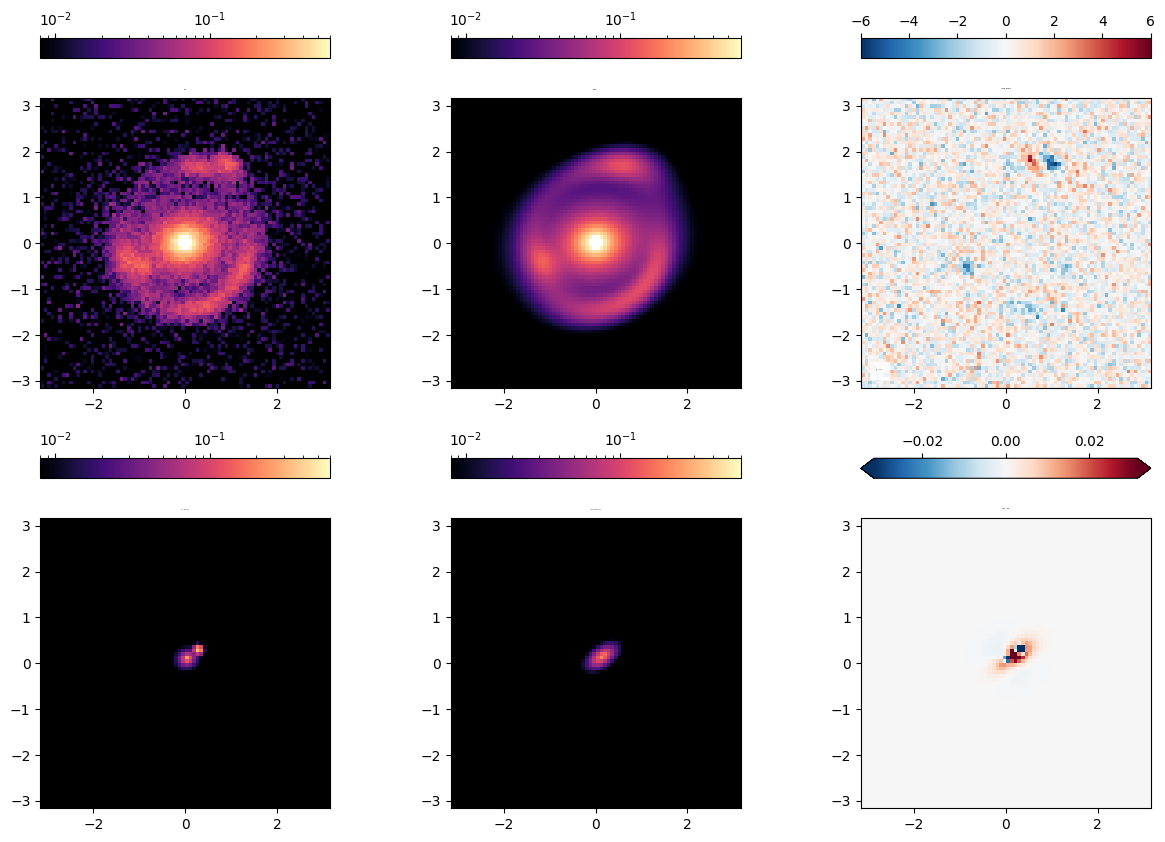

In [16]:
# the best-fit values are in unconstrained space so we transform them here
best_fit = prob_model.constrain(best_fit_unconst)
kwargs_best_fit = prob_model.params2kwargs(best_fit)

fig = plotter.model_summary(lens_image, kwargs_best_fit, show_source=True,
                            kwargs_grid_source=dict(pixel_scale_factor=1))
plt.show()

In [17]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_best_fit)

print("="*80)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': Array(0.00838449, dtype=float64),
                  'center_y': Array(-0.01354251, dtype=float64),
                  'e1': Array(0.16518948, dtype=float64),
                  'e2': Array(0.07869255, dtype=float64),
                  'theta_E': Array(1.50131211, dtype=float64)},
                 {'dec_0': 0.0,
                  'gamma1': Array(-0.00922363, dtype=float64),
                  'gamma2': Array(0.06051618, dtype=float64),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': Array(0.95408864, dtype=float64),
                        'amp': Array(8.60037026, dtype=float64),
                        'center_x': Array(-0.00105034, dtype=float64),
                        'center_y': Array(-0.0015009, dtype=float64),
                        'e1': Array(0.13162718, dtype=float64),
                        'e2': Array(0.03247811, dtype=float64),
                        'n_sersic': Array(2.89629169, dtype=float64)}],
 'kwargs

### Switching to a pixelated source model

In [18]:
# choose the source plane resolution, position and size
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.3,
    'grid_center': (kwargs_best_fit['kwargs_source'][0]['center_x'], 
                    kwargs_best_fit['kwargs_source'][0]['center_y']), 
    'grid_shape': (1, 1), # arcsec
}
source_model_pixelated = LightModel(['PIXELATED'], kwargs_pixelated=kwargs_pixelated_source)

# Setup a new LensImage instance
lens_image_pix = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                           lens_mass_model_class=deepcopy(lens_mass_model_input),
                           source_model_class=source_model_pixelated,
                           lens_light_model_class=deepcopy(lens_light_model_input),
                           kwargs_numerics=kwargs_numerics_fit)

# let's retrieve a version of the previous source evaluated on the new source plane
x_src, y_src = lens_image_pix.SourceModel.pixel_grid.pixel_coordinates
init_source_pixels = lens_image.SourceModel.surface_brightness(x_src, y_src, kwargs_best_fit['kwargs_source']) * lens_image.Grid.pixel_area

In [19]:
# define how to regularize source pixels
regul_model = RegularizationModel([('source', 0, 'SPARSITY_STARLET'),
                                   ('source', 0, 'SPARSITY_BLWAVELET'), 
                                   ('source', 0, 'POSITIVITY')])

# initialize the weights based on the previous best fit model
# takes a bit of time, as it samples and propagates noise realizations
noise_var = lens_image.Noise.C_D_model(lens_image.model(**kwargs_best_fit))
regul_model.initialize(lens_image_pix, kwargs_best_fit, noise_var=noise_var, num_samples=1000)

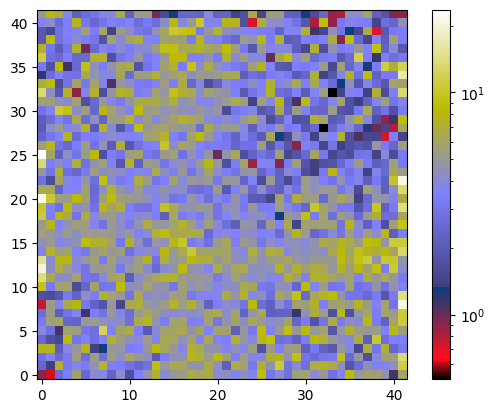

In [20]:
# visualize the computed weights
weights_list = regul_model.get_weights()

plt.imshow(weights_list[0][0], origin='lower', norm=LogNorm(), cmap='gist_stern')
plt.colorbar()
plt.show()

In [21]:
class ProbModelPixSource(NumpyroModel):
    
    def model(self):
        # Parameters of the source
        source_pixels = numpyro.param('source_pixels', 
                                      init_value=init_source_pixels, 
                                      event_dim=init_source_pixels.shape,
                                        constraint=constraints.real)
        prior_source = [{'pixels': source_pixels}]

        # Parameters of the lens
        cx = best_fit['light_center_x']  # fixed
        cy = best_fit['light_center_y']  # fixed

        # Parameters of the lens light, with center relative the lens mass
        prior_lens_light = [
        {'amp': numpyro.sample('light_amp', dist.LogNormal(np.log10(best_fit['light_amp']), 0.05)), 
         'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(best_fit['light_R_sersic'], 0.05)), 
         'n_sersic': numpyro.sample('light_n', dist.Normal(best_fit['light_n'], 0.05)), 
         'e1': numpyro.sample('light_e1', dist.TruncatedNormal(best_fit['light_e1'], 0.02, low=-0.3, high=0.3)),
         'e2': numpyro.sample('light_e2', dist.TruncatedNormal(best_fit['light_e2'], 0.02, low=-0.3, high=0.3)),
         'center_x': cx, 
         'center_y': cy}
        ]

        prior_lens = [
        # power-law
        {
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(best_fit['lens_theta_E'], 0.03)),
         'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(best_fit['lens_e1'], 0.02, low=-0.3, high=0.3)),
         'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(best_fit['lens_e2'], 0.02, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('lens_center_x', dist.Normal(cx, 0.005)), 
         'center_y': numpyro.sample('lens_center_y', dist.Normal(cy, 0.005))},
        # external shear, with fixed origin
        {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(best_fit['lens_gamma1'], 0.02, low=-0.3, high=0.3)), 
         'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(best_fit['lens_gamma2'], 0.02, low=-0.3, high=0.3)), 
         'ra_0': 0.0, 'dec_0': 0.0}
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image_pix.model(**model_params)
        
        # estimate the error per pixel
        model_var = lens_image_pix.Noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)

        # factors in regularization log-probability
        hyperparams = [
            # NOTE: we could also optimize / infer these hyperparameters
            {'lambda_0': 3., 'lambda_1': 3.},
            {'lambda_0': 3.},
            {'strength': 3.},
        ]
        numpyro.factor('source_regul', regul_model.log_prob(model_params, hyperparams))
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'pixels': params['source_pixels']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2']}]}
        return kw

prob_model_pix = ProbModelPixSource()
print("Number of parameters:", prob_model_pix.num_parameters)


Number of parameters: 1776


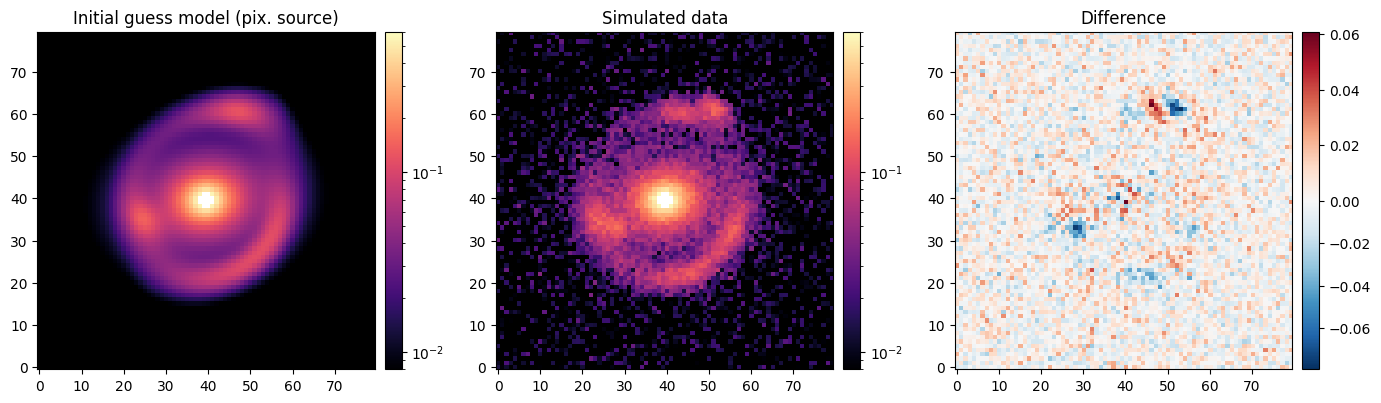

In [22]:
init_params_pix = {k: v for k, v in best_fit.items() if 'lens' in k or 'light' in k}
init_params_pix['source_pixels'] = init_source_pixels

init_params_pix_unconst = prob_model_pix.unconstrain(init_params_pix)  # UNconstrained space
kwargs_init_pix = prob_model_pix.params2kwargs(init_params_pix)  # constrained space
initial_model = lens_image_pix.model(**kwargs_init_pix)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model (pix. source)")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [23]:
loss_pix = Loss(prob_model_pix)
print("Initial loss =", loss_pix(init_params_pix_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = -19027.114694548025


In [24]:
optimizer_pix = OptaxOptimizer(loss_pix, loss_norm_optim=data.size)

# optimizer setting
init_learning_rate = 5e-4

best_fit_pix_unconst, logL, extra_fields, runtime \
    = optimizer_pix.run(init_params_pix_unconst, max_iterations=6000, 
                        init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")

optax.adabelief: 100%|██████████| 6000/6000 [00:16<00:00, 363.77it/s]


Runtime: 16.500460386276245


Loss at best-fit: -19419.534019361774


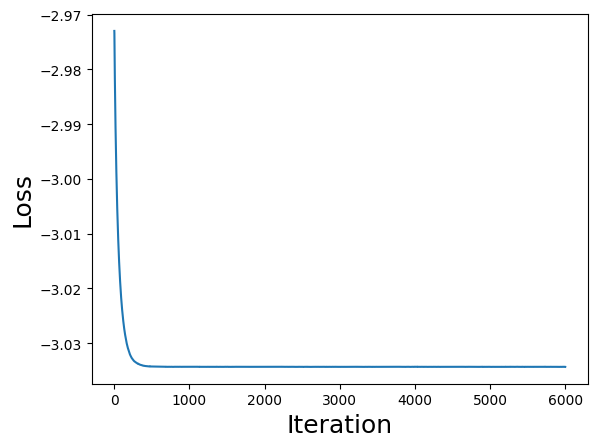

In [25]:
print("Loss at best-fit:", loss_pix(best_fit_pix_unconst))

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
#ax.set_xlim(0, 10)
plt.show()

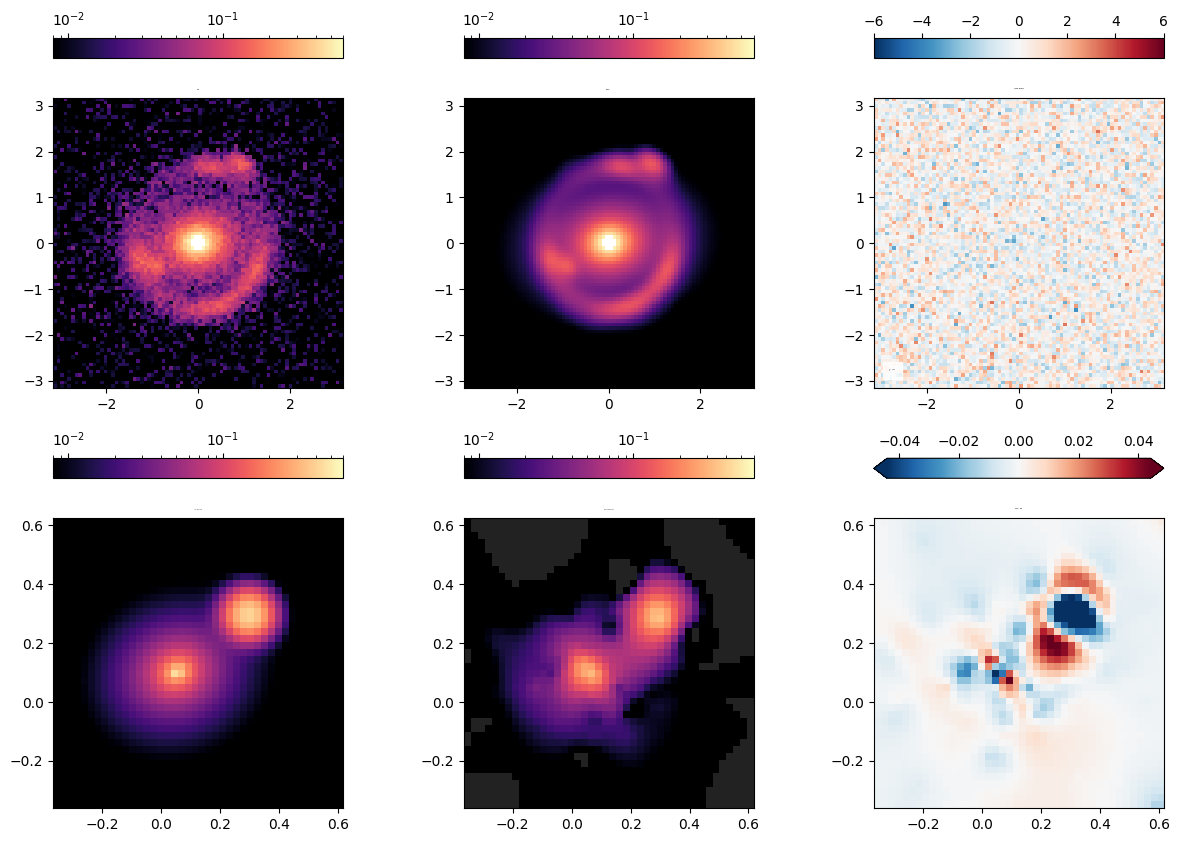

In [26]:
# the best-fit values are in unconstrained space so we transform them here
best_fit_pix = prob_model_pix.constrain(best_fit_pix_unconst)
kwargs_best_fit_pix = prob_model_pix.params2kwargs(best_fit_pix)

# we evaluate the reference 'true' source on the same grid as the input
ref_source_pixels = source_model_input.surface_brightness(x_src, y_src, kwargs_source_input) * lens_image.Grid.pixel_area
plotter.set_ref_source(ref_source_pixels)

fig = plotter.model_summary(lens_image_pix, kwargs_best_fit_pix, show_source=True,
                            kwargs_grid_source=dict(pixel_scale_factor=1))
plt.show()

## Posterior sampling with HMC

Using `backjax` with window adaptation strategy to tune the HMC parameters

In [27]:
@jax.jit
def logdensity_fn(args):
    return -loss_pix(args)

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.6, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
    progress_bar=True, 
)

num_steps_adaptation = 1000

start = time.time()
(last_state, adapted_settings), info = adapt.run(jax.random.PRNGKey(0), best_fit_pix_unconst, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

Running window adaptation



Time taken by HMC (blackjax) warmup phase: 1782.5131485462189
Warmup state (lens only, unconstrained) {'lens_center_x': Array(0.00289455, dtype=float64), 'lens_center_y': Array(-0.00298097, dtype=float64), 'lens_e1': Array(1.0475088, dtype=float64), 'lens_e2': Array(0.37055674, dtype=float64), 'lens_gamma1': Array(-0.05778125, dtype=float64), 'lens_gamma2': Array(0.25968322, dtype=float64), 'lens_theta_E': Array(1.50231259, dtype=float64)}


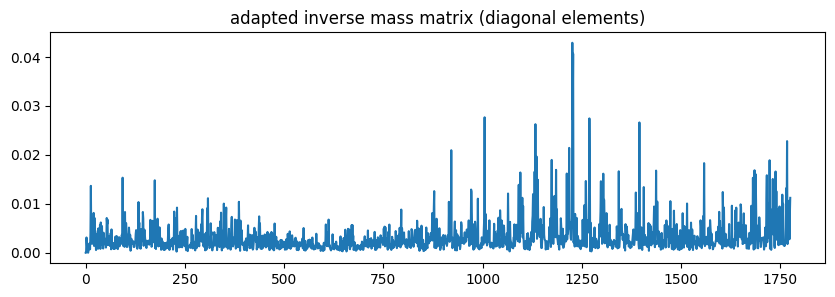

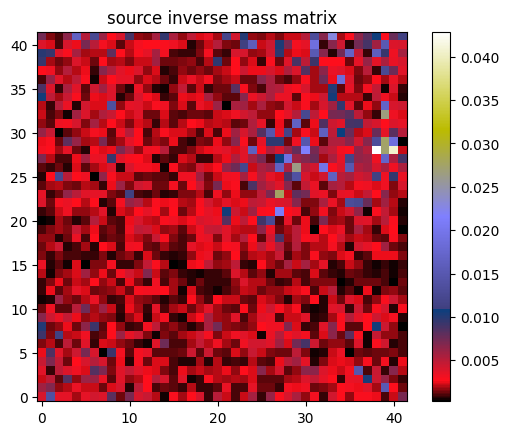

In [28]:
# visualize the inverse mass matrix we will use for HMC

plt.figure(figsize=(10, 3))
plt.title("adapted inverse mass matrix (diagonal elements)")
plt.plot(adapted_settings['inverse_mass_matrix'])
plt.show()

nx_src, ny_src = x_src.shape

plt.figure()
plt.title("source inverse mass matrix")
plt.imshow(adapted_settings['inverse_mass_matrix'][-nx_src*ny_src:].reshape(nx_src, ny_src), cmap='gist_stern')
plt.colorbar()
plt.show()

In [ ]:
# setup the NUTS kernel with adapted settings
kernel = blackjax.nuts(logdensity_fn, **adapted_settings).step

# define the inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

num_steps_nuts = 3000

start = time.time()
states, infos = inference_loop(jax.random.PRNGKey(1), kernel, last_state, num_steps_nuts)
_ = states.position['lens_theta_E'].block_until_ready()
print("Time taken by HMC (blackjax) main phase:", time.time()-start)   

In [ ]:
plt.figure()
plt.plot(infos.energy)
plt.xlabel("iterations")
plt.ylabel("energy")
plt.show()

plt.figure()
for k, v in infos.momentum.items():
    if 'lens' in k:
        plt.plot((v - np.median(v)) / np.median(v), label=k, alpha=0.3)
plt.legend()
plt.xlabel("iterations")
plt.ylabel("momentum (normalized)")
plt.show()

plt.figure()
for k, v in infos.momentum.items():
    if 'light' in k:
        plt.plot((v - np.median(v)) / np.median(v), label=k, alpha=0.3)
plt.legend()
plt.xlabel("iterations")
plt.ylabel("momentum (normalized)")
plt.show()

In [ ]:
acceptance_rate = np.mean(infos.acceptance_rate)
num_divergent = np.mean(infos.is_divergent)

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

In [ ]:
# retrieve the HMC posterior samples
hmc_samples = jax.vmap(prob_model_pix.constrain)(states.position)

In [ ]:
# create the input vector for reference (here only lens-related parameters for simplicity)
input_params = {
    'lens_theta_E': kwargs_all_input['kwargs_lens'][0]['theta_E'],
    'lens_e1': kwargs_all_input['kwargs_lens'][0]['e1'],
    'lens_e2': kwargs_all_input['kwargs_lens'][0]['e2'],
    'lens_center_x': kwargs_all_input['kwargs_lens'][0]['center_x'],
    'lens_center_y': kwargs_all_input['kwargs_lens'][0]['center_y'],
    'lens_gamma1': kwargs_all_input['kwargs_lens'][1]['gamma1'],
    'lens_gamma2': kwargs_all_input['kwargs_lens'][1]['gamma2'],
    'light_amp': kwargs_all_input['kwargs_lens_light'][0]['amp'],
    'light_R_sersic': kwargs_all_input['kwargs_lens_light'][0]['R_sersic'],
    'light_n': kwargs_all_input['kwargs_lens_light'][0]['n_sersic'],
    'light_e1': kwargs_all_input['kwargs_lens_light'][0]['e1'],
    'light_e2': kwargs_all_input['kwargs_lens_light'][0]['e2'],
    'light_center_x': kwargs_all_input['kwargs_lens_light'][0]['center_x'],
    'light_center_y': kwargs_all_input['kwargs_lens_light'][0]['center_y'],
}

In [ ]:
# format labels and markers for getdist
var_names_and_ranges = {
    'lens_theta_E': 0.3, 'lens_e1': 0.3, 'lens_e2': 0.3, 'lens_gamma1': 0.3, 'lens_gamma2': 0.3,
    'light_R_sersic': 0.3, 'light_e1': 0.3, 'light_e2': 0.3,
}
var_names = list(var_names_and_ranges.keys())
ranges = list(var_names_and_ranges.values())

fig = None
#fig = corner.corner(prior_samples, 
#                    color='#00000033', 
#                    var_names=var_names,
#                    range=ranges, 
#                    smooth=0.8,
#                    fill_contours=True,
#                    plot_datapoints=False,
#                    hist_kwargs=dict(label="Prior distribution", linewidth=1),
#                    fig=fig)
fig = corner.corner(hmc_samples, 
                    color='tab:red', 
                    var_names=var_names,
                    fill_contours=True,
                    truths=input_params, truth_color='black', 
                    hist_kwargs=dict(label="Hamiltonian Monte Carlo", linewidth=2),
                    fig=fig)
axes = np.array(fig.get_axes()).reshape(len(var_names), len(var_names))
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, len(var_names)-1].legend(handles, labels, fontsize=18)
plt.show()